In [31]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [32]:
%cd /gdrive/My Drive/AN2DL/Homework1

/gdrive/My Drive/AN2DL/Homework1


### Import libraries

In [33]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [34]:
# Random seed for reproducibility
seed = 43

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [35]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# UC Merced Land Use Dataset

http://weegee.vision.ucmerced.edu/datasets/landuse.html

Aerial RGB images of 256x256 pixels. Images belongs to 21 different classes representing the land uses.

Class labels:
0. agricultural
1. airplane
2. baseballdiamond
3. beach
4. buildings
5. chaparral
6. denseresidential
7. forest
8. freeway
9. golfcourse
10. harbor
11. intersection
12. mediumresidential
13. mobilehomepark
14. overpass
15. parkinglot
16. river
17. runway
18. sparseresidential
19. storagetanks
20. tenniscourt

In [12]:
# Load the dataset to be used for classification
!unzip training_dataset_homework1.zip

Archive:  training_dataset_homework1.zip
   creating: training_dataset_homework1/training_data_final/
   creating: training_dataset_homework1/training_data_final/Test/
   creating: training_dataset_homework1/training_data_final/Test/Species1/
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00000.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00001.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00002.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00003.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00004.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00005.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00006.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Species1/00007.jpg  
  inflating: training_dataset_homework1/training_data_final/Test/Spec

In [41]:
# Dataset folders 
dataset_dir = 'training_dataset_homework1'
training_dir = os.path.join(dataset_dir, 'training_data_final/Training')
validation_dir = os.path.join(dataset_dir, 'training_data_final/Validation')
test_dir = os.path.join(dataset_dir, 'training_data_final/Test')

# Data Loader

### Typically, data is too large to be loaded as a NumPy array.
### We need a different strategy..

In [37]:
print("Depth 0 (training_data_final")
print("-------")
!ls training_dataset_homework1

Depth 0 (training_data_final
-------
training_data_final


In [38]:
print("Depth 2 (e.g., training_data_final/training)")
print("------------------------")
!ls training_dataset_homework1/training_data_final/Training

Depth 2 (e.g., training_data_final/training)
------------------------
Species1  Species2  Species3  Species4	Species5  Species6  Species7  Species8


In [39]:
print("Depth 3 (e.g., training_data_final/training/agricultural)")
print("----------------------------")
!ls training_dataset_homework1/training_data_final/Training/species3

Depth 3 (e.g., training_data_final/training/agricultural)
----------------------------
ls: cannot access 'training_dataset_homework1/training_data_final/Training/species3': No such file or directory


In [42]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 2671 images belonging to 8 classes.
Found 336 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


In [43]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [44]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [45]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1


NameError: ignored

# Data Augmentation

##### ImageDataGenerator allows to perform data augmentation

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

Rotation: {'theta': -23.09672601661326, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': -4, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.7690327398338673, 'zy': 1.0654399235676888, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

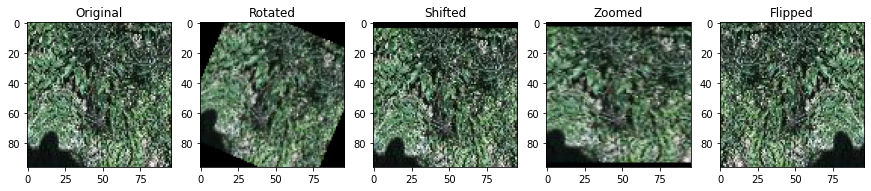

In [46]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

Transform: {'theta': -23.09672601661326, 'tx': 49, 'ty': 16, 'shear': 0, 'zx': 0.8962834334866838, 'zy': 1.2154824945691587, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


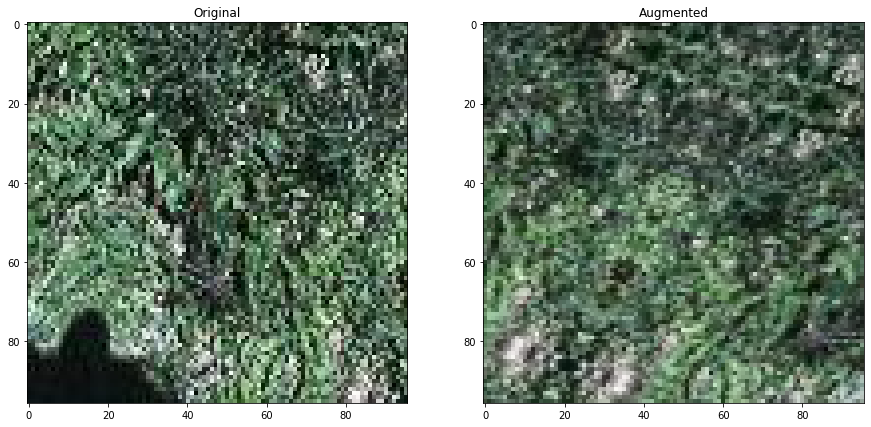

In [48]:
# Combine multiple transformations
gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True, 
                         fill_mode='reflect')

# Get random transformation
t = gen.get_random_transform(img_shape=(96, 96), seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

# Training with and without data augmentation

In [49]:
# Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rescale=1/255.) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=8,
                                                           shuffle=True,
                                                           seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 2671 images belonging to 8 classes.
Found 336 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


In [50]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

Found 2671 images belonging to 8 classes.


### Models metadata

In [51]:
input_shape = (256, 256, 3)
epochs = 200

### CNN model

In [52]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=21, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [53]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [54]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [56]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200


InvalidArgumentError: ignored

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")

In [ ]:
# Evaluate on test
# Trainined with no data augmentation
model_noaug = tfk.models.load_model("data_augmentation_experiments/CNN_NoAug_Best")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)

# Visualize the activations

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[3] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [ ]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in model_aug.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model_aug.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

In [ ]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)